# Developing a Probabilistic Model of Length of Hospital Stay
---
# Table of contents
1. [Introduction](#introduction)
2. [Preprocessing](#preprocessing)
    1. [Data Cleaning](#cleaning)
    2. [Feature Engineering](#feateng)
3. [Model Development](#modeldev)
    1. [Model 1: LightGBM](#lightgbm)
    2. [Model 2: LightGBM w/ Bayesian Optimization (HyperOpt)](#hyperopt)
    3. [Model 3: LightGBM w/ HyperOpt and Synthetic Oversampling](#smote)
4. [Discrimination Threshold Analysis](#discrimination)

# Introduction<a name="introduction"></a>
---

My objective in this notebook is, as (strongly) suggested by the title above, to develop a model capable of accurately predicting the probability that a given patient will require a "long" hospital stay (presently defined as "more than 5 days of hospitalization") after undergoing surgery. To this end, I decided to implement LightGBM on account of its versatility, power, and efficiency. More details/information about this project can be found in "LOS_Report.docx" (in the Github project folder). Data is not available for reproduction, sorry!

In [ ]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('HospTrain.csv')
test = pd.read_csv('HospTest.csv')
test.head()

In [3]:
Results = test[['ID1']]
test = test.drop('ID1', axis=1)

In [4]:
pd.options.display.max_columns = None

In [6]:
df.shape

(80000, 292)

# Preprocessing <a name="preprocessing"></a>
---
## Data Cleaning <a name="cleaning"></a>

Text(0.5, 1.0, 'Missing value in the dataset')

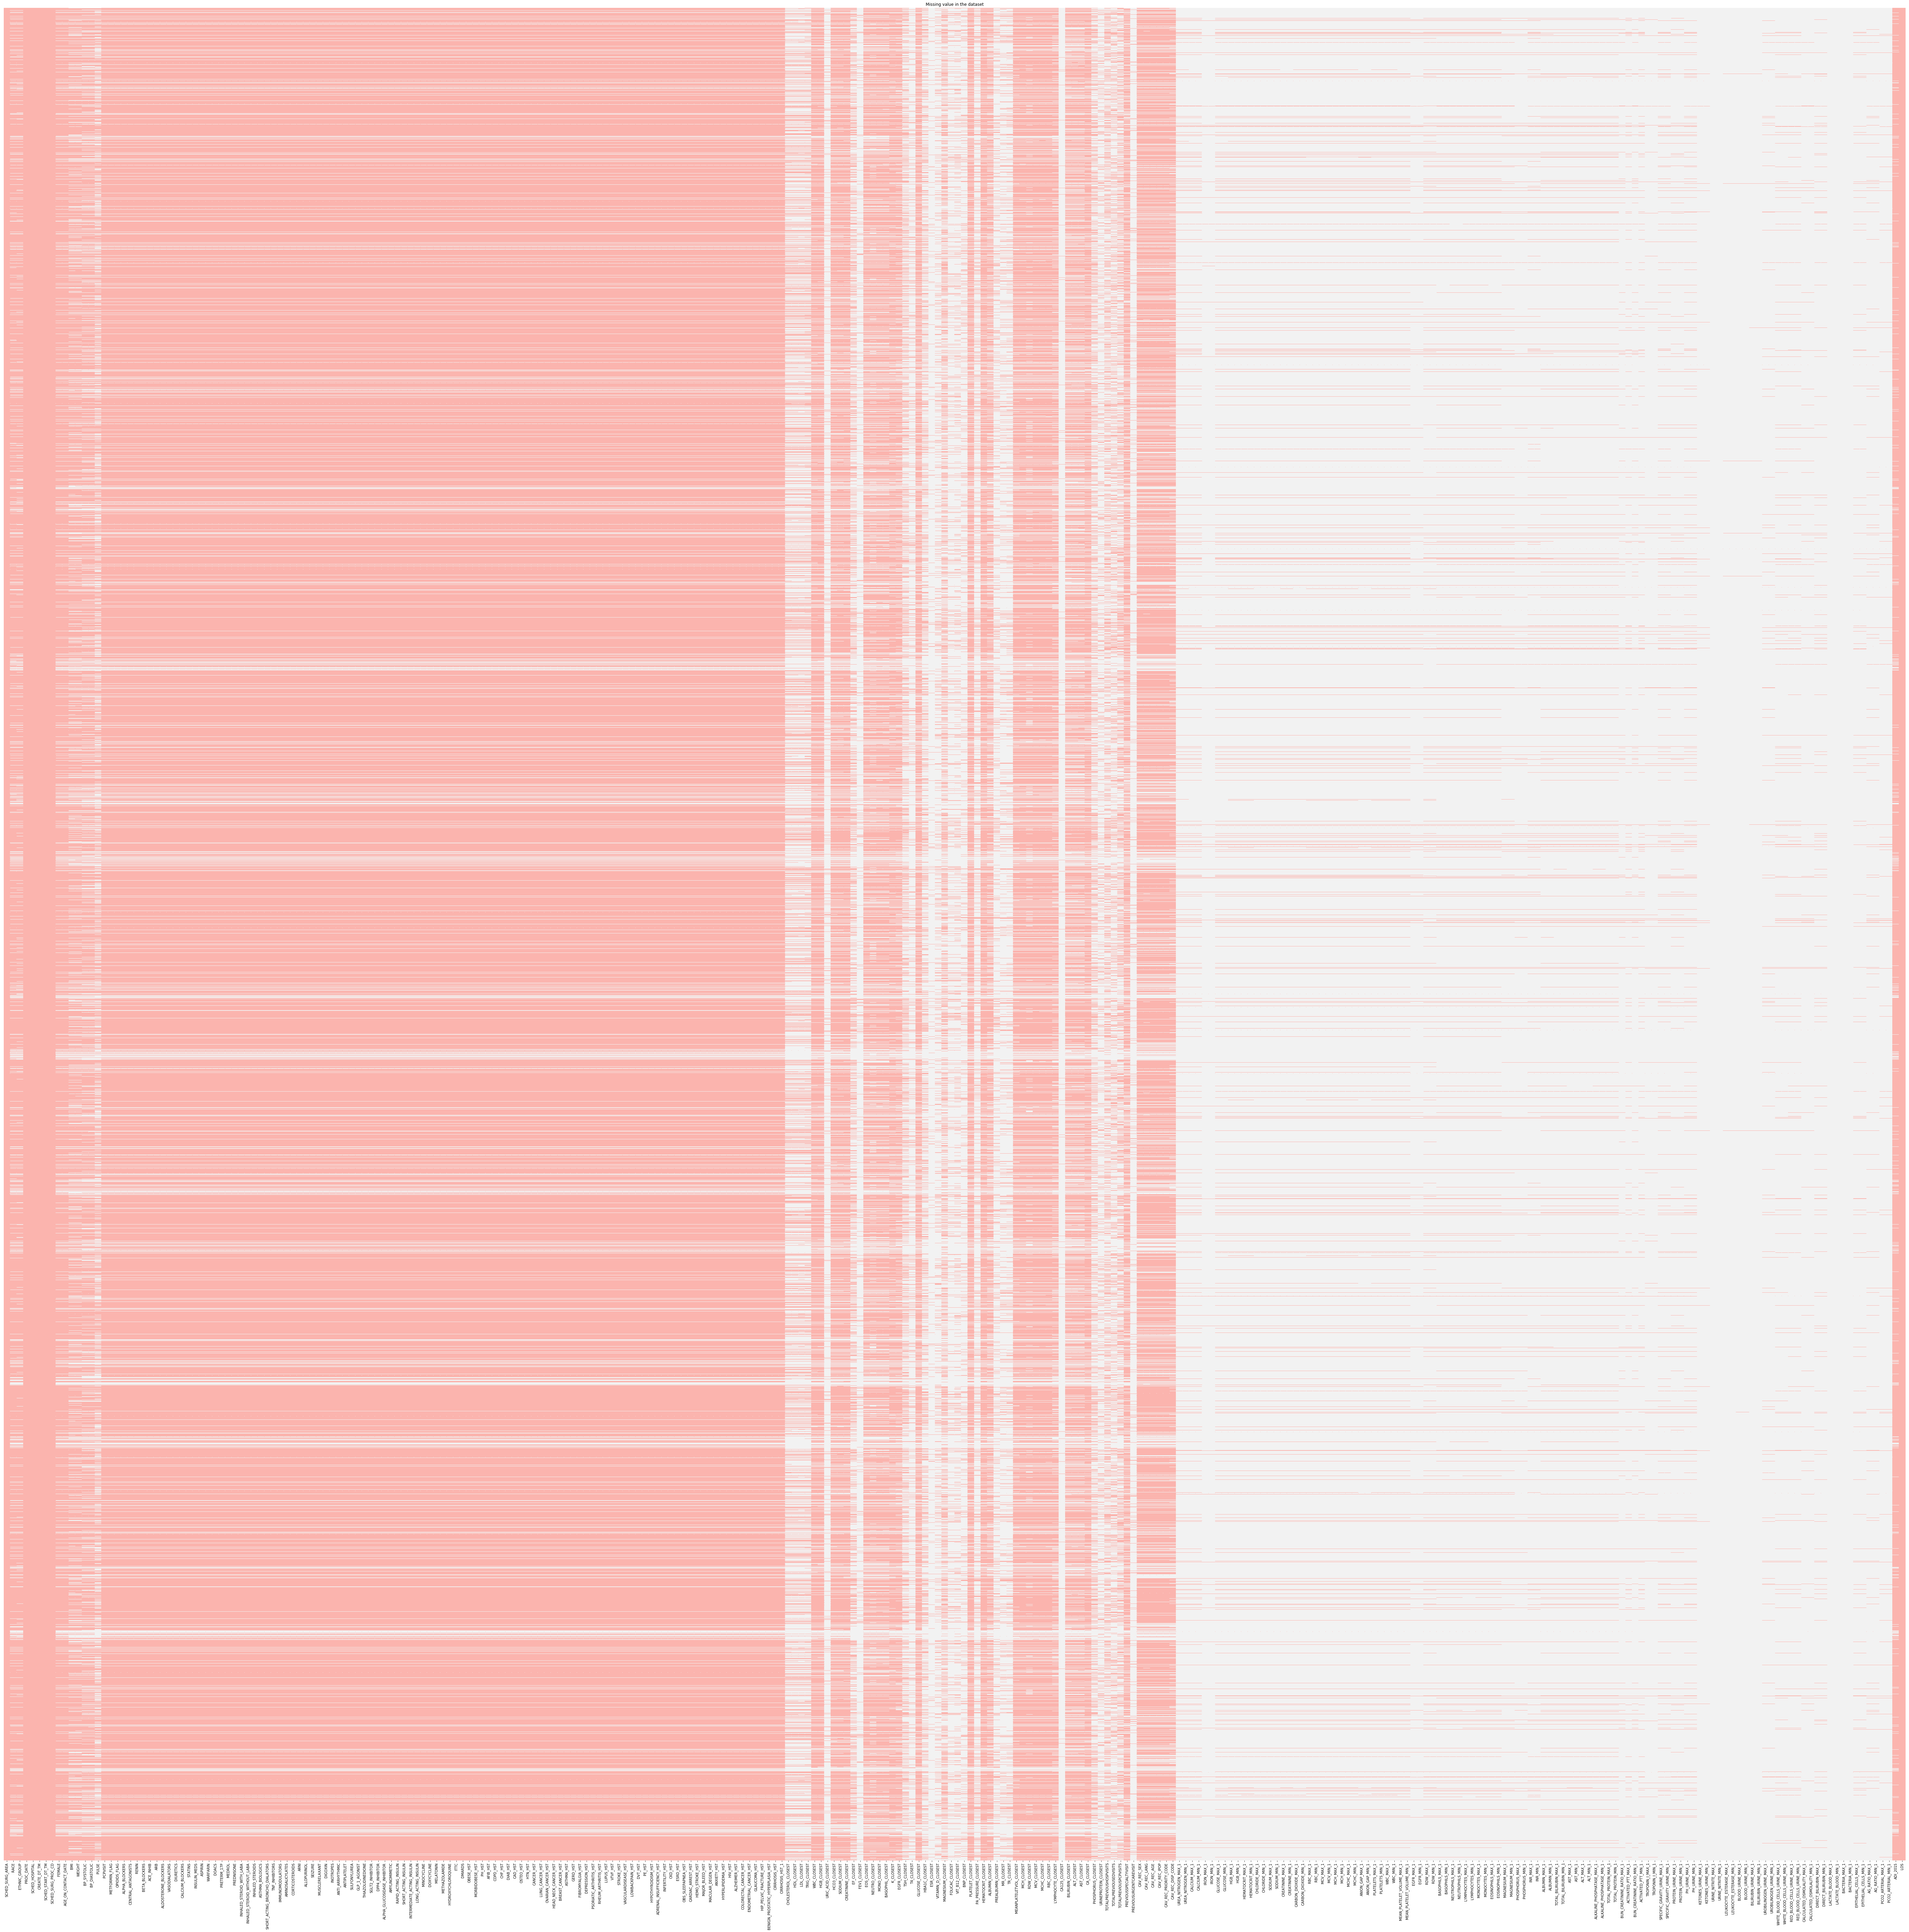

In [6]:

plt.figure(figsize=(100,100))
sns.heatmap(df.isnull(),cbar=False,cmap='Pastel1',yticklabels=False)
plt.title('Missing value in the dataset')

In [ ]:
pd.options.display.max_columns = None
df.head()

In [11]:
df.isnull().sum()

SCHED_SURG_AREA                      0
RACE                             10503
ETHNIC_GROUP                     11864
PROC_DATE                            0
SCHED_HOSPITAL                       0
CREATE_DT_TM                         0
SCHED_START_DT_TM                    0
SCHED_SURG_PROC_CD                   0
FEMALE                           10187
AGE_ON_CONTACT_DATE              10187
BMI                              19259
WEIGHT                           18970
BP_SYSTOLIC                      21147
BP_DIASTOLIC                     21203
PULSE                            34728
PCPVISIT                         10187
METFORMIN_FLAG                   10187
OPIOIDS_FLAG                     10187
ALPHA_BLOCKERS                   10187
CENTRAL_ANTAGONISTS              10187
RENIN                            10187
BETA_BLOCKERS                    10187
ACE_INHIB                        10187
ARB                              10187
ALDOSTERONE_BLOCKERS             10187
VASODIALATORS            

### Copying DataFrame in order to run analysis on both complete dataset and dataset with dropped columns

In [7]:
df2 = df.copy()

In [8]:
df2.shape

(80000, 292)

In [ ]:
test2 = test.copy()
test2.head()

In [10]:
test2.shape

(11202, 291)

### Dropping columns in which more than 80% of values are NaN

In [11]:
df = df.loc[:, df.isnull().sum() < 0.8*df.shape[0]]
test = test.loc[:, test.isnull().sum() < 0.8*test.shape[0]]

In [12]:
df.shape

(80000, 167)

In [13]:
test.shape

(11202, 166)

In [14]:
df2.shape

(80000, 292)

In [ ]:
df.head()

Text(0.5, 1.0, 'Missing value in the dataset')

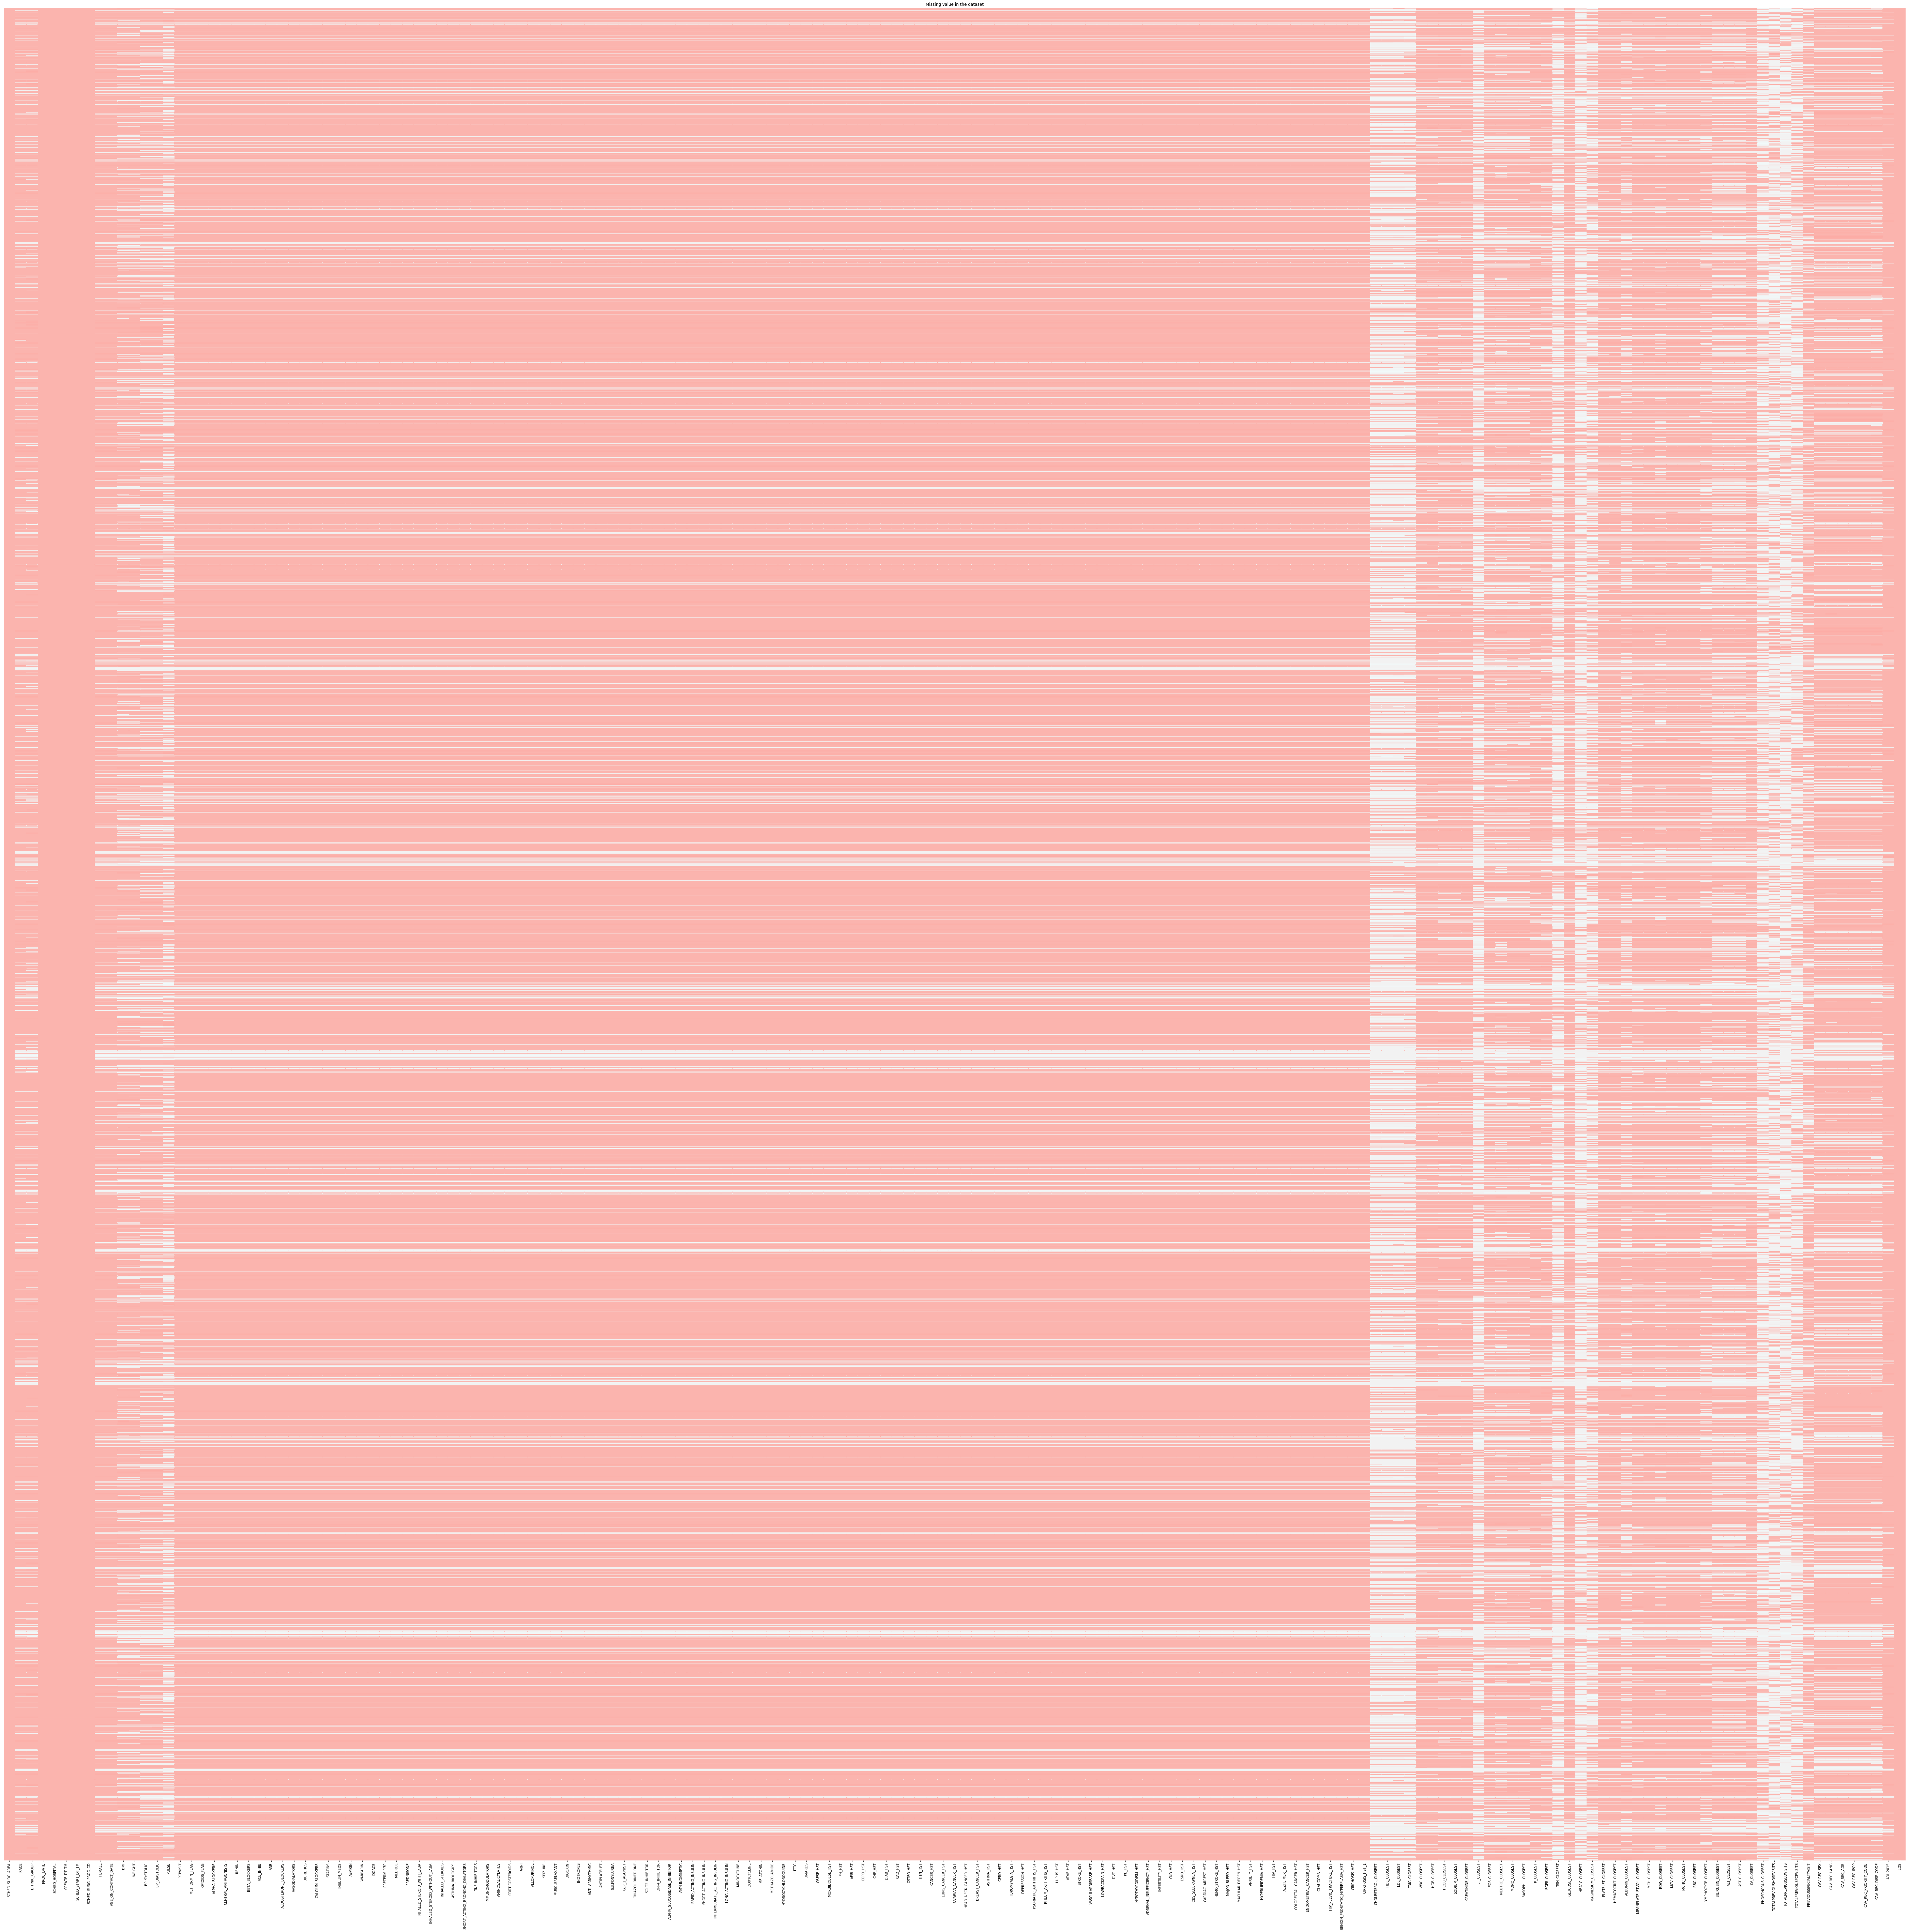

In [15]:
plt.figure(figsize=(100,100))
sns.heatmap(df.isnull(),cbar=False,cmap='Pastel1',yticklabels=False)
plt.title('Missing value in the dataset')

In [21]:
pd.set_option('display.max_rows', 200)
df.dtypes

SCHED_SURG_AREA                      object
RACE                                 object
ETHNIC_GROUP                         object
PROC_DATE                            object
SCHED_HOSPITAL                       object
CREATE_DT_TM                         object
SCHED_START_DT_TM                    object
SCHED_SURG_PROC_CD                    int64
FEMALE                              float64
AGE_ON_CONTACT_DATE                 float64
BMI                                 float64
WEIGHT                              float64
BP_SYSTOLIC                         float64
BP_DIASTOLIC                        float64
PULSE                               float64
PCPVISIT                            float64
METFORMIN_FLAG                      float64
OPIOIDS_FLAG                        float64
ALPHA_BLOCKERS                      float64
CENTRAL_ANTAGONISTS                 float64
RENIN                               float64
BETA_BLOCKERS                       float64
ACE_INHIB                       

## Feature Engineering <a name="feateng"></a>
Feature Engineering From Date/Time and Encoding Categorical Features With CatBoost

In [16]:
import datetime
df['PROC_DATE'] = pd.to_datetime(df['PROC_DATE'])
df2['PROC_DATE'] = pd.to_datetime(df2['PROC_DATE'])

test['PROC_DATE'] = pd.to_datetime(test['PROC_DATE'])
test2['PROC_DATE'] = pd.to_datetime(test2['PROC_DATE'])

In [17]:
df['CREATE_DT_TM'] = pd.to_datetime(df['CREATE_DT_TM'])
df['SCHED_START_DT_TM'] = pd.to_datetime(df['SCHED_START_DT_TM'])

df2['CREATE_DT_TM'] = pd.to_datetime(df2['CREATE_DT_TM'])
df2['SCHED_START_DT_TM'] = pd.to_datetime(df2['SCHED_START_DT_TM'])

test['CREATE_DT_TM'] = pd.to_datetime(test['CREATE_DT_TM'])
test['SCHED_START_DT_TM'] = pd.to_datetime(test['SCHED_START_DT_TM'])

test2['CREATE_DT_TM'] = pd.to_datetime(test2['CREATE_DT_TM'])
test2['SCHED_START_DT_TM'] = pd.to_datetime(test2['SCHED_START_DT_TM'])

In [18]:
X_train = df.drop(['LOS'], axis=1)
y_train = df['LOS']

X_train2 = df2.drop(['LOS'], axis=1)
y_train2 = df2['LOS']

In [19]:
y_train = np.where(y_train > 5, 1,0)

y_train2 = np.where(y_train2 > 5, 1, 0)
y_train2 = pd.DataFrame(y_train2)

In [20]:
X_train2.shape

(80000, 291)

In [21]:
test2.shape

(11202, 291)

In [22]:
import category_encoders as ce
cbencoder = ce.CatBoostEncoder(cols=['SCHED_SURG_AREA', 'RACE','ETHNIC_GROUP','SCHED_HOSPITAL','CAV_REC_LANG','CAV_REC_IPOP','CAV_REC_PRIORITY_CODE','CAV_REC_DISP_CODE'])
cbencoder.fit(X_train, y_train)
X_train = cbencoder.transform(X_train)

cbencoder2 = ce.CatBoostEncoder()
cbencoder2.fit(X_train2, y_train2)
X_train2 = cbencoder2.transform(X_train2)

test = cbencoder.transform(test)
test2 = cbencoder2.transform(test2)

In [ ]:
X_train['CAV_REC_SEX'] = X_train['CAV_REC_SEX'].map({'F': 1,'M':0})
X_train2['CAV_REC_SEX'] = X_train2['CAV_REC_SEX'].map({'F': 1,'M':0})

test['CAV_REC_SEX'] = test['CAV_REC_SEX'].map({'F': 1,'M':0})
test2['CAV_REC_SEX'] = test2['CAV_REC_SEX'].map({'F': 1,'M':0})
X_train2.head()

In [24]:
X_train.dtypes
X_train = X_train.drop('SCHED_SURG_PROC_CD',axis=1)


In [25]:
X_train2 = X_train2.drop('SCHED_SURG_PROC_CD',axis=1)

test = test.drop('SCHED_SURG_PROC_CD',axis=1)
test2 = test2.drop('SCHED_SURG_PROC_CD',axis=1)

In [26]:
X_train['PROC_MONTH'] = X_train['PROC_DATE'].dt.month
X_train['PROC_DAY'] = X_train['PROC_DATE'].dt.day
X_train['PROC_QUARTER'] = X_train['PROC_DATE'].dt.quarter
X_train['PROC_DAYWEEK'] = X_train['PROC_DATE'].dt.dayofweek
X_train['CREATE_MONTH'] = X_train['CREATE_DT_TM'].dt.month
X_train['CREATE_DAY'] = X_train['CREATE_DT_TM'].dt.day
X_train['CREATE_QUARTER'] = X_train['CREATE_DT_TM'].dt.quarter
X_train['CREATE_DAYWEEK'] = X_train['CREATE_DT_TM'].dt.dayofweek

X_train2['PROC_MONTH'] = X_train2['PROC_DATE'].dt.month
X_train2['PROC_DAY'] = X_train2['PROC_DATE'].dt.day
X_train2['PROC_QUARTER'] = X_train2['PROC_DATE'].dt.quarter
X_train2['PROC_DAYWEEK'] = X_train2['PROC_DATE'].dt.dayofweek
X_train2['CREATE_MONTH'] = X_train2['CREATE_DT_TM'].dt.month
X_train2['CREATE_DAY'] = X_train2['CREATE_DT_TM'].dt.day
X_train2['CREATE_QUARTER'] = X_train2['CREATE_DT_TM'].dt.quarter
X_train2['CREATE_DAYWEEK'] = X_train2['CREATE_DT_TM'].dt.dayofweek


test['PROC_MONTH'] = test['PROC_DATE'].dt.month
test['PROC_DAY'] = test['PROC_DATE'].dt.day
test['PROC_QUARTER'] = test['PROC_DATE'].dt.quarter
test['PROC_DAYWEEK'] = test['PROC_DATE'].dt.dayofweek
test['CREATE_MONTH'] = test['CREATE_DT_TM'].dt.month
test['CREATE_DAY'] = test['CREATE_DT_TM'].dt.day
test['CREATE_QUARTER'] = test['CREATE_DT_TM'].dt.quarter
test['CREATE_DAYWEEK'] = test['CREATE_DT_TM'].dt.dayofweek

test2['PROC_MONTH'] = test2['PROC_DATE'].dt.month
test2['PROC_DAY'] = test2['PROC_DATE'].dt.day
test2['PROC_QUARTER'] = test2['PROC_DATE'].dt.quarter
test2['PROC_DAYWEEK'] = test2['PROC_DATE'].dt.dayofweek
test2['CREATE_MONTH'] = test2['CREATE_DT_TM'].dt.month
test2['CREATE_DAY'] = test2['CREATE_DT_TM'].dt.day
test2['CREATE_QUARTER'] = test2['CREATE_DT_TM'].dt.quarter
test2['CREATE_DAYWEEK'] = test2['CREATE_DT_TM'].dt.dayofweek

In [27]:
X_train['PROC_HOUR'] = X_train['SCHED_START_DT_TM'].dt.hour
X_train['WEEKEND'] = np.where(X_train['PROC_DAYWEEK'].isin([6,5]),1,0)

X_train2['PROC_HOUR'] = X_train2['SCHED_START_DT_TM'].dt.hour
X_train2['WEEKEND'] = np.where(X_train2['PROC_DAYWEEK'].isin([6,5]),1,0)

test['PROC_HOUR'] = test['SCHED_START_DT_TM'].dt.hour
test['WEEKEND'] = np.where(test['PROC_DAYWEEK'].isin([6,5]),1,0)

test2['PROC_HOUR'] = test2['SCHED_START_DT_TM'].dt.hour
test2['WEEKEND'] = np.where(test2['PROC_DAYWEEK'].isin([6,5]),1,0)

In [28]:
X_train = X_train.drop(['PROC_DATE','CREATE_DT_TM','SCHED_START_DT_TM'],axis=1)

test = test.drop(['PROC_DATE','CREATE_DT_TM','SCHED_START_DT_TM'],axis=1)

In [29]:
X_train2 = X_train2.drop(['PROC_DATE','CREATE_DT_TM','SCHED_START_DT_TM'],axis=1)
test2 = test2.drop(['PROC_DATE','CREATE_DT_TM','SCHED_START_DT_TM'],axis=1)

In [30]:
X_train2.shape

(80000, 297)

In [31]:
X_train.head()

,SCHED_SURG_AREA,RACE,ETHNIC_GROUP,SCHED_HOSPITAL,FEMALE,AGE_ON_CONTACT_DATE,BMI,WEIGHT,BP_SYSTOLIC,BP_DIASTOLIC,PULSE,PCPVISIT,METFORMIN_FLAG,OPIOIDS_FLAG,ALPHA_BLOCKERS,CENTRAL_ANTAGONISTS,RENIN,BETA_BLOCKERS,ACE_INHIB,ARB,ALDOSTERONE_BLOCKERS,VASODIALATORS,DIURETICS,CALCIUM_BLOCKERS,STATINS,INSULIN_MEDS,ASPIRIN,WARFARIN,DOACS,PRETERM_17P,MEDROL,PREDNISONE,INHALED_STEROID_WITH_LABA,INHALED_STEROID_WITHOUT_LABA,INHALED_STEROIDS,ASTHMA_BIOLOGICS,SHORT_ACTING_BRONCHO_DIALATORS,TNF_INHIBITORS,IMMUNOMODULATORS,AMINOSALICYLATES,CORTICOSTEROIDS,ARNI,ALLOPURINOL,SEIZURE,MUSCLERELAXANT,DIGOXIN,INOTROPES,ANTI_ARRHYTHMIC,ANTIPLATELET,SULFONYLUREA,GLP_1_AGONIST,THIAZOLIDINEDIONE,SGLT2_INHIBITOR,DPP4_INHIBITOR,ALPHA_GLUCOSIDASE_INHIBITOR,AMYLINOMIMETIC,RAPID_ACTING_INSULIN,SHORT_ACTING_INSULIN,INTERMEDIATE_ACTING_INSULIN,LONG_ACTING_INSULIN,MINOCYCLINE,DOXYCYCLINE,MELATONIN,METHAZOLAMIDE,HYDROXYCHLOROQUINE,ITTC,DMARDS,OBESE_HST,MORBIDOBESE_HST,PH_HST,AFIB_HST,COPD_HST,CHF_HST,DIAB_HST,CAD_HST,OSTEO_HST,HTN_HST,CANCER_HST,LUNG_CANCER_HST,OVARIAN_CANCER_HST,HEAD_NECK_CANCER_HST,BREAST_CANCER_HST,ASTHMA_HST,GERD_HST,FIBROMYALGIA_HST,DEPRESSION_HST,PSORIATIC_ARTHRITIS_HST,RHEUM_ARTHRITIS_HST,LUPUS_HST,VTVF_HST,STROKE_HST,VASCULARDISEASE_HST,LOWBACKPAIN_HST,DVT_HST,PE_HST,HYPOTHYROIDISM_HST,ADRENAL_INSUFFICIENCY_HST,INFERTILITY_HST,CKD_HST,ESRD_HST,OBS_SLEEPAPNEA_HST,CARDIAC_ARREST_HST,HEMO_STROKE_HST,MAJOR_BLEED_HST,MACULAR_DEGEN_HST,ANXIETY_HST,HYPERLIPIDEMIA_HST,HIV_HST,ALZHEIMER_HST,COLORECTAL_CANCER_HST,ENDOMETRIAL_CANCER_HST,GLAUCOMA_HST,HIP_PELVIC_FRACTURE_HST,BENIGN_PROSTATIC_HYPERPLASIA_HST,CIRRHOSIS_HST,CIRRHOSIS_HST_1,CHOLESTEROL_CLOSEST,HDL_CLOSEST,LDL_CLOSEST,TRIG_CLOSEST,WBC_CLOSEST,HGB_CLOSEST,HCO3_CLOSEST,SODIUM_CLOSEST,CREATININE_CLOSEST,EF_CLOSEST,EOS_CLOSEST,NEUTRO_CLOSEST,MONO_CLOSEST,BASOPHIL_CLOSEST,K_CLOSEST,EGFR_CLOSEST,TSH_CLOSEST,GLUCOSE_CLOSEST,HBA1C_CLOSEST,MAGNESIUM_CLOSEST,PLATELET_CLOSEST,HEMATOCRIT_CLOSEST,ALBUMIN_CLOSEST,MEANPLATELETVOL_CLOSEST,MCH_CLOSEST,RDW_CLOSEST,MCV_CLOSEST,MCHC_CLOSEST,RBC_CLOSEST,LYMPHOCYTE_CLOSEST,BILIRUBIN_CLOSEST,ALT_CLOSEST,AST_CLOSEST,CA_CLOSEST,PHOSPHORUS_CLOSEST,TOTALPREVIOUSHOSPVISITS,TOTALPREVIOUSEDVISITS,TOTALPREVIOUSPCPVISITS,PREVIOUSSPECIALTYVISIT,CAV_REC_SEX,CAV_REC_LANG,CAV_REC_AGE,CAV_REC_IPOP,CAV_REC_PRIORITY_CODE,CAV_REC_DISP_CODE,ADI_2015,PROC_MONTH,PROC_DAY,PROC_QUARTER,PROC_DAYWEEK,CREATE_MONTH,CREATE_DAY,CREATE_QUARTER,CREATE_DAYWEEK,PROC_HOUR,WEEKEND
0,0.177794,0.202888,0.205222,0.172930,0.0,73.3,28.21,3056.0,102.0,70.0,83.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,169.0,28.0,101.0,201.0,4.7,13.9,23.0,137.0,1.22,76.0,1.5,47.0,15.6,0.6,4.2,58.0,NaN,91.0,5.6,1.6,145.0,41.4,3.2,7.6,30.9,16.7,91.9,33.7,4.51,35.3,0.6,13.0,26.0,9.0,NaN,1.0,NaN,NaN,3.0,0.0,0.223058,72.0,0.289500,0.226418,0.284746,68.493519,2,19,1,0,2,13,1,1,7,0
1,0.001114,0.202888,0.205222,0.108867,1.0,26.1,25.61,2240.0,96.0,58.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,6.2,11.0,NaN,NaN,NaN,NaN,0.4,74.6,6.5,0.3,NaN,NaN,NaN,NaN,NaN,NaN,177.0,32.1,NaN,7.7,31.1,13.2,91.3,34.1,3.52,18.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,1.0,0.223058,23.0,0.289500,0.166633,0.228032,75.203533,2,22,1,3,1,23,1,1,8,0
2,0.290693,0.202888,0.240353,0.282161,1.0,19.0,3

In [44]:
X_train.nunique()

SCHED_SURG_AREA                       44
RACE                                  17
ETHNIC_GROUP                           5
SCHED_HOSPITAL                        18
FEMALE                                 2
AGE_ON_CONTACT_DATE                  973
BMI                                 4105
WEIGHT                              3582
BP_SYSTOLIC                          169
BP_DIASTOLIC                         119
PULSE                                134
PCPVISIT                               2
METFORMIN_FLAG                         2
OPIOIDS_FLAG                           2
ALPHA_BLOCKERS                         2
CENTRAL_ANTAGONISTS                    2
RENIN                                  2
BETA_BLOCKERS                          2
ACE_INHIB                              2
ARB                                    2
ALDOSTERONE_BLOCKERS                   2
VASODIALATORS                          2
DIURETICS                              2
CALCIUM_BLOCKERS                       2
STATINS         

### Checking for class imbalance

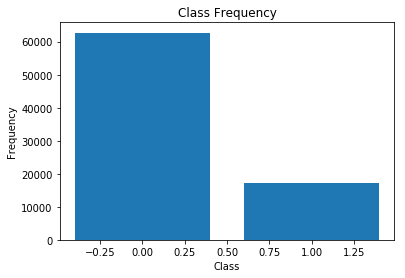

In [45]:
classes = y_train2.values
unique, counts = np.unique(classes, return_counts=True)

plt.bar(unique,counts)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# 

In [32]:
imputed_test = pd.read_csv('imputedTest1.csv',header=None)

In [33]:
x_pred = imputed_test.drop([172],axis=1)

# Model Development<a name="modeldev"></a>
---
## Model 1: LightGBM<a name="lightgbm"></a>

Complete DataSet; Imbalanced Target; NaN Handled Internally by LGBM; No Hyperparameter Optimization

In [34]:
import xgboost as xgb
import lightgbm as lgb
import hyperopt as hp
import hyperband as hyp
from hyperopt import Trials,fmin,STATUS_OK
from hyperband import HyperbandSearchCV
import sklearn
sklearn.metrics.SCORERS.keys()
#from skopt import BayesSearchCV
from lightgbm import LGBMClassifier

/Users/coreyrobinson/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/coreyrobinson/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/Users/coreyrobinson/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is requir

In [35]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size = 0.2, random_state = 2)

In [36]:
lgb_train_baseline = lgb.Dataset(X_train2, y_train2)
lgb_val_baseline = lgb.Dataset(X_val2, y_val2)

In [37]:
lgb_params_baseline = {
    'boosting_type': 'goss',
    'objective': 'binary',
    'metric': 'auc',
    #'max_depth' : 100,
    #'num_leaves' : 100,
    #'learning_rate': 0.1,
    'num_threads' : -1,
    #'scale_pos_weight' : 0.2,
    #'early_stopping_round' : 100,
    #'min_data_in_leaf' : 200,
     #'pos_bagging_fraction' : 1.0,
     #'neg_bagging_fraction' : 0.5,
     #'bagging_freq' : 3,
     #'max_delta_step' : 100.0,
    #'top_rate' : 0.1,
    #'other_rate' : 0.5,
    #'lambda_l1' : 10,
    #'lambda_l2' : 10
}

In [38]:
lgb_baseline = lgb.train(params=lgb_params_baseline, train_set=lgb_train_baseline,
               num_boost_round=1000, verbose_eval=200, valid_sets=[lgb_val_baseline, lgb_train_baseline],
               valid_names = ['Evaluation','Train'])

[200]	Train's auc: 0.897861	Evaluation's auc: 0.814917
[400]	Train's auc: 0.939923	Evaluation's auc: 0.811019
[600]	Train's auc: 0.962582	Evaluation's auc: 0.808315
[800]	Train's auc: 0.975349	Evaluation's auc: 0.805593
[1000]	Train's auc: 0.982446	Evaluation's auc: 0.801624


Wow, AUC of 0.98...Too bad that it's super overfit! Moving on...

In [39]:
baseline_probs_train = lgb_baseline.predict(X_train2)

In [40]:
baseline_probs_val = lgb_baseline.predict(X_val2)

In [41]:
baseline_probs_test = lgb_baseline.predict(test2)

### Evaluating baseline LightGBM model

In [54]:
fpr, tpr, thresholds = metrics.roc_curve(y_train2, baseline_probs_train)
metrics.auc(fpr, tpr)

0.9824462618273334

In [55]:
fpr, tpr, thresholds = metrics.roc_curve(y_val2, baseline_probs_val)
metrics.auc(fpr, tpr)

0.8016239655907331

In [56]:
from sklearn.metrics import roc_curve, roc_auc_score

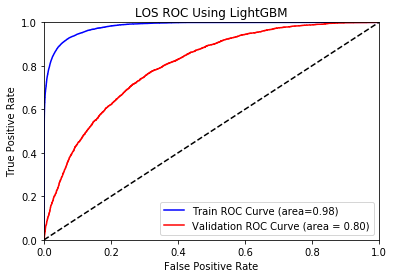

In [57]:
plt.plot(roc_curve(y_train2, baseline_probs_train)[0],roc_curve(y_train2, baseline_probs_train)[1],
         color='blue', label='Train ROC Curve (area=%0.2f)' % roc_auc_score(y_train2, baseline_probs_train))
plt.plot(roc_curve(y_val2, baseline_probs_val)[0],roc_curve(y_val2, baseline_probs_val)[1], 
         color = 'red', label='Validation ROC Curve (area = %0.2f)' % roc_auc_score(y_val2, baseline_probs_val))

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LOS ROC Using LightGBM')
plt.legend()
plt.show()

### The ROC curves above confirm that the baseline model is severely overfit, i.e. it does not generalize well to unseen data.

In [82]:
results_baseline

array([0.99549416, 0.99615427, 0.99127619, ..., 0.99190295, 0.9960162 ,
       0.99239931])

## Model 2: LightGBM w/ Bayesian Optimization (HyperOpt)<a name="hyperopt"></a>
Complete Dataset; Imbalanced Target; NaN Handled Internally By LGBM

In [58]:
HOpt_space = {

# hp.choice.choice will select 1 value from the given list  , 'dart', 'goss', 'rf'
    #Just stick with one boosting type
    'boosting_type':hp.hp.choice('boosting_type', ['goss']),
    #np.arange is telling hyperopt to choose value within that range
    'num_leaves':hp.hp.choice('num_leaves', np.arange(10, 300,1, dtype=int)),
    'max_depth':hp.hp.choice('max_depth', np.arange(1,50,dtype=int)),
    'min_data_in_leaf':hp.hp.choice('min_data_in_leaf', np.arange(10,50,dtype=int)),
    'subsample':hp.hp.quniform('subsample',0.5,1.0,0.05),
    'colsample_bytree':hp.hp.quniform('colsample_bytree',0.5,1.0,0.05),
    'min_child_weight':hp.hp.quniform('min_child_weight', 100, 1000,100),
    'reg_alpha': hp.hp.uniform('reg_alpha', 0.0, 100.0),
    'reg_lambda': hp.hp.uniform('reg_lambda', 0.0, 100.0),
    'learning_rate': hp.hp.quniform('learning_rate', 0.025, 0.5,0.025),
    #'feature_fraction': hp.hp.loguniform('feature_fraction', -4, 0),
    #'bagging_fraction': hp.hp.loguniform('bagging_fraction', -4, 0),
    'bagging_frequency':hp.hp.choice('bagging_frequency', np.arange(1, 30, dtype=int)),
    #'drop_rate': hp.hp.loguniform('drop_rate', -4, 0),
    #'scale_pos_weight': hp.hp.uniform('scale_pos_weight', 6.0, 10.0),
    #'n_estimators':hp.hp.quniform('n_estimators', 100, 1000, 1),
    #'num_class' : 1, 
    'metric' : 'auc',
    'nthread': 4, 
    'max_bin': hp.hp.choice('max_bin', np.arange(100, 400, dtype=int))
    }

In [59]:
def objective_m(params, n_folds=3):


    model = lgb.cv(params = params,
              train_set = lgb_train_baseline,
              num_boost_round = 1000,
              early_stopping_rounds = 10,
             nfold = n_folds)
  
    
  
    # returns the best average loss on validation set 
    
    loss = 1 - (max(model['auc-mean']))
    return loss


bayes_trials = Trials()
MAX_EVALS = 100 # this controls the runtime 

lgbm_best_m = fmin(fn = objective_m, space = HOpt_space, algo = hp.tpe.suggest, 
max_evals = MAX_EVALS, trials = bayes_trials)

100%|██████████| 100/100 [01:53<00:00,  1.08it/s, best loss: 0.18431334330571403]


In [60]:
lgbm_best_m

{'bagging_frequency': 19,
 'boosting_type': 0,
 'colsample_bytree': 0.6000000000000001,
 'learning_rate': 0.05,
 'max_bin': 28,
 'max_depth': 22,
 'min_child_weight': 100.0,
 'min_data_in_leaf': 30,
 'num_leaves': 170,
 'reg_alpha': 2.9070154005801974,
 'reg_lambda': 9.968470454118611,
 'subsample': 0.5}

In [42]:
lgb_params_hyp = {
    'boosting_type': 'goss',
    'objective': 'binary',
    'metric': 'auc',
    #'max_depth' : 7,
    #'num_leaves' : 267,
    #'learning_rate': 0.025,
    'num_threads' : 4,
    #'scale_pos_weight' : 0.2,
    #'early_stopping_round' : 100,
    #'min_data_in_leaf' : 200,
     #'pos_bagging_fraction' : 1.0,
     #'neg_bagging_fraction' : 0.5,
    # 'bagging_freq' : 10,
     #'max_delta_step' : 100.0,
    #'top_rate' : 0.1,
    #'other_rate' : 0.5,
    #'reg_alpha' : 1.2432152,
    #'reg_lambda' : 66.26446,
    #'bagging_fraction': 0.862967,
    #'feature_fraction': 0.527246252514,
    #'mind_child_weight': 300.0
    'bagging_frequency': 5,
    'colsample_bytree': 0.2,
    'feature_fraction_bynode': 0.2,
    'learning_rate': 0.1,
    'max_bin': 10,
    'max_depth': 9,
    'min_child_weight': 400.0,
    'min_data_in_leaf': 500,
    'num_leaves': 60,
    'reg_alpha': 4.7495371867292704,
    'reg_lambda': 80.038396715861545,
    'subsample': .95
}

In [43]:
lgb_2 = lgb.train(params=lgb_params_hyp, train_set=lgb_train_baseline,
               num_boost_round=1000, verbose_eval=200, valid_sets=[lgb_val_baseline, lgb_train_baseline],
               valid_names = ['Evaluation','Train'])

[200]	Train's auc: 0.824051	Evaluation's auc: 0.816189
[400]	Train's auc: 0.835147	Evaluation's auc: 0.818095
[600]	Train's auc: 0.843738	Evaluation's auc: 0.819269
[800]	Train's auc: 0.851155	Evaluation's auc: 0.819757
[1000]	Train's auc: 0.857268	Evaluation's auc: 0.82002


In [63]:
train_prob_2 = lgb_2.predict(X_train2)
val_prob_2 = lgb_2.predict(X_val2)
test_prob_2 = lgb_2.predict(test2)

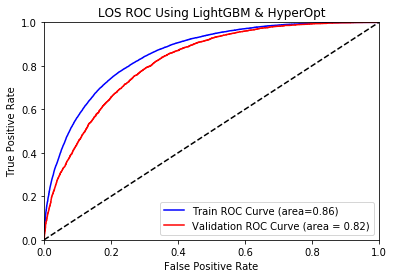

In [64]:
plt.plot(roc_curve(y_train2, train_prob_2)[0],roc_curve(y_train2, train_prob_2)[1],
         color='blue', label='Train ROC Curve (area=%0.2f)' % roc_auc_score(y_train2, train_prob_2))
plt.plot(roc_curve(y_val2, val_prob_2)[0],roc_curve(y_val2, val_prob_2)[1], 
         color = 'red', label='Validation ROC Curve (area = %0.2f)' % roc_auc_score(y_val2, val_prob_2))

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LOS ROC Using LightGBM & HyperOpt')
plt.legend()
plt.show()

In [83]:
results_model2 = lgb_baseline.predict(x_pred)

In [87]:
results_model2.max()

0.53487932035754


## Model 3: LightGBM w/ HyperOpt and Synthetic Oversampling<a name="smote"></a>

Complete Dataset; SMOTE To Address Imbalanced Target Class; NaN handled by predicting missing values with Sklearn's IterativeImputer

---

When the target class distribution is significantly imbalanced, many classification algorithms will be biased in their predictions towards the larger class and will thus fail to model the decision boundary accurately. In circumstances wherein the majority class of an imbalanced dataset is positive and the minority class is negative, a classifier trained on the same dataset will yield high sensitivity (i.e. the proportion of correct positive classifications to the total number of true positives) and low specificity (i.e. the proportion of correct negative classifications to the total number of true negatives). 

Several methods have been proposed for dealing with significant class imbalances: 

1. Undersampling of majority class
2. Oversampling or upsampling of minority class
3. Discrimination threshold tuning

As undersampling would result in greater information loss than I would prefer, I will instead opt to upsample the minority class using Synthetic Minority Oversampling Technique (SMOTE). While overfitting is a concern when implementing any oversampling techniques, SMOTE is substantially more robust to overfitting than is random oversampling. Whereas random sampling effectively replicates existing observations, SMOTE synthesizes new observations based on the distances between existing observations in the feature space.

In [44]:
bin_train = X_train.loc[:, X_train.nunique() < 3]
cont_train = X_train.loc[:, X_train.nunique() > 2]

In [45]:
bin_test = test.loc[:, test.nunique() < 3]
cont_test = test.loc[:, test.nunique() > 2]
bin_train.head()

,FEMALE,PCPVISIT,METFORMIN_FLAG,OPIOIDS_FLAG,ALPHA_BLOCKERS,CENTRAL_ANTAGONISTS,RENIN,BETA_BLOCKERS,ACE_INHIB,ARB,ALDOSTERONE_BLOCKERS,VASODIALATORS,DIURETICS,CALCIUM_BLOCKERS,STATINS,INSULIN_MEDS,ASPIRIN,WARFARIN,DOACS,PRETERM_17P,MEDROL,PREDNISONE,INHALED_STEROID_WITH_LABA,INHALED_STEROID_WITHOUT_LABA,INHALED_STEROIDS,ASTHMA_BIOLOGICS,SHORT_ACTING_BRONCHO_DIALATORS,TNF_INHIBITORS,IMMUNOMODULATORS,AMINOSALICYLATES,CORTICOSTEROIDS,ARNI,ALLOPURINOL,SEIZURE,MUSCLERELAXANT,DIGOXIN,INOTROPES,ANTI_ARRHYTHMIC,ANTIPLATELET,SULFONYLUREA,GLP_1_AGONIST,THIAZOLIDINEDIONE,SGLT2_INHIBITOR,DPP4_INHIBITOR,ALPHA_GLUCOSIDASE_INHIBITOR,AMYLINOMIMETIC,RAPID_ACTING_INSULIN,SHORT_ACTING_INSULIN,INTERMEDIATE_ACTING_INSULIN,LONG_ACTING_INSULIN,MINOCYCLINE,DOXYCYCLINE,MELATONIN,METHAZOLAMIDE,HYDROXYCHLOROQUINE,ITTC,DMARDS,OBESE_HST,MORBIDOBESE_HST,PH_HST,AFIB_HST,COPD_HST,CHF_HST,DIAB_HST,CAD_HST,OSTEO_HST,HTN_HST,CANCER_HST,LUNG_CANCER_HST,OVARIAN_CANCER_HST,HEAD_NECK_CANCER_HST,BREAST_CANCER_HST,ASTHMA_HST,GERD_HST,FIBROMYALGIA_HST,DEPRESSION_HST,PSORIATIC_ARTHRITIS_HST,RHEUM_ARTHRITIS_HST,LUPUS_HST,VTVF_HST,STROKE_HST,VASCULARDISEASE_HST,LOWBACKPAIN_HST,DVT_HST,PE_HST,HYPOTHYROIDISM_HST,ADRENAL_INSUFFICIENCY_HST,INFERTILITY_HST,CKD_HST,ESRD_HST,OBS_SLEEPAPNEA_HST,CARDIAC_ARREST_HST,HEMO_STROKE_HST,MAJOR_BLEED_HST,MACULAR_DEGEN_HST,ANXIETY_HST,HYPERLIPIDEMIA_HST,HIV_HST,ALZHEIMER_HST,COLORECTAL_CANCER_HST,ENDOMETRIAL_CANCER_HST,GLAUCOMA_HST,HIP_PELVIC_FRACTURE_HST,BENIGN_PROSTATIC_HYPERPLASIA_HST,CIRRHOSIS_HST,CIRRHOSIS_HST_1,CAV_REC_SEX,WEEKEND
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### Handling NaN with IterativeImputer

In [46]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
imp_regr = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=30, random_state=1, n_jobs=-1), missing_values=np.nan, sample_posterior=False, 
                                 max_iter=5, tol=0.001, 
                                 n_nearest_features=5, initial_strategy='mean')
X_train_cont = imp_regr.fit_transform(cont_train)

imp_class = IterativeImputer(estimator=ExtraTreesClassifier(n_estimators=30, random_state=1, n_jobs=-1), missing_values=np.nan, sample_posterior=False, 
                                 max_iter=5, tol=0.001, 
                                 n_nearest_features=5, initial_strategy='most_frequent')
X_train_bin = imp_class.fit_transform(bin_train)

/Users/coreyrobinson/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/coreyrobinson/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [47]:
test_cont = imp_regr.transform(cont_test)
test_bin = imp_class.transform(bin_test)

In [48]:
X_trains = [X_train_cont,X_train_bin]

In [49]:
x_train_cont_pd = pd.DataFrame(X_train_cont)
test_cont_pd = pd.DataFrame(test_cont)
test_bin_pd = pd.DataFrame(test_bin)
x_train_bin_pd = pd.DataFrame(X_train_bin)
X_train_pd = pd.concat([x_train_cont_pd ,x_train_bin_pd ], axis=1, ignore_index=True)
test_pd = pd.concat([test_cont_pd, test_bin_pd], axis=1, ignore_index=True)

np.savetxt("imputedSM.csv", X_train_pd, delimiter=",")
np.savetxt('imputedSMtest.csv',test_pd, delimiter=',')

df_imp = pd.read_csv('imputedSM.csv', header=None)
test_imp = pd.read_csv('imputedSMtest.csv', header=None)
X_train_sm = df_imp
y_train_sm = pd.DataFrame(y_train)

In [102]:
from collections import Counter
y_train_sm[0].value_counts()

1    50225
0    50107
Name: 0, dtype: int64

In [103]:
print(17292/62708)
print(62708/17292)

0.2757542897237992
3.6264168401572983


### Using SMOTE to synthesize balanced target classes

In [50]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(ratio='minority')
X_train_SM, y_train_SM = smote.fit_sample(X_train_sm, y_train_sm)
np.bincount(y_train_SM)

Using TensorFlow backend.
/Users/coreyrobinson/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([62708, 62708])

In [51]:
X_train, X_val, y_train, y_val = train_test_split(X_train_SM, y_train_SM, test_size = 0.2, random_state = 2)

### Running LightGBM with HyperOpt 

In [52]:
lgb_train_sm = lgb.Dataset(X_train, y_train)
lgb_val_sm = lgb.Dataset(X_val, y_val)

In [85]:
def objective_m(params, n_folds=3):


    model = lgb.cv(params = params,
              train_set = lgb_train_sm,
              num_boost_round = 1000,
              early_stopping_rounds = 10,
             nfold = n_folds)
  
    
  
    # returns the best average loss on validation set 
    
    loss = 1 - (max(model['auc-mean']))
    return loss


bayes_trials = Trials()
MAX_EVALS = 100 # this controls the runtime 

lgbm_best_m = fmin(fn = objective_m, space = HOpt_space, algo = hp.tpe.suggest, 
max_evals = MAX_EVALS, trials = bayes_trials)

100%|██████████| 100/100 [01:55<00:00,  1.04s/it, best loss: 0.06490481911860913]


In [86]:
lgbm_best_m

{'bagging_frequency': 9,
 'boosting_type': 0,
 'colsample_bytree': 0.5,
 'learning_rate': 0.025,
 'max_bin': 103,
 'max_depth': 29,
 'min_child_weight': 100.0,
 'min_data_in_leaf': 32,
 'num_leaves': 226,
 'reg_alpha': 11.988563199713443,
 'reg_lambda': 46.654920781576315,
 'subsample': 0.75}

In [60]:
lgb_params_hyp = {
    'boosting_type': 'goss',
    'objective': 'binary',
    'metric': 'auc',
    #'max_depth' : 7,
    #'num_leaves' : 267,
    #'learning_rate': 0.025,
    'num_threads' : 4,
    #'scale_pos_weight' : 0.2,
    #'early_stopping_round' : 100,
    #'min_data_in_leaf' : 200,
     #'pos_bagging_fraction' : 1.0,
     #'neg_bagging_fraction' : 0.5,
    # 'bagging_freq' : 10,
     #'max_delta_step' : 100.0,
    #'top_rate' : 0.1,
    #'other_rate' : 0.5,
    #'reg_alpha' : 1.2432152,
    #'reg_lambda' : 66.26446,
    #'bagging_fraction': 0.862967,
    #'feature_fraction': 0.527246252514,
    #'mind_child_weight': 300.0
     'bagging_frequency': 22,
     'colsample_bytree': 0.5,
     'learning_rate': 0.025,
     'max_bin': 90,
     'max_depth': 38,
     'min_child_weight': 300.0,
     'min_data_in_leaf': 5,
     'num_leaves': 196,
     'reg_alpha': 0.7339122129225384,
     'reg_lambda': 81.5894069958651,
     'subsample': 1.0}


In [61]:
lgb_baseline = lgb.train(params=lgb_params_hyp, train_set=lgb_train_sm,
               num_boost_round=1000, verbose_eval=200, valid_sets=[lgb_val_sm, lgb_train_sm],
               valid_names = ['Evaluation','Train'])

[200]	Train's auc: 0.941874	Evaluation's auc: 0.935462
[400]	Train's auc: 0.948014	Evaluation's auc: 0.939438
[600]	Train's auc: 0.951902	Evaluation's auc: 0.940992
[800]	Train's auc: 0.955075	Evaluation's auc: 0.941865
[1000]	Train's auc: 0.957777	Evaluation's auc: 0.94234


In [104]:
train_probs_3 = lgb_baseline.predict(X_train)
val_probs_3 = lgb_baseline.predict(X_val)
test_probs_3 = lgb_baseline.predict(test_imp)

In [107]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, train_probs_3)
metrics.auc(fpr, tpr)

0.9690195546984902

In [106]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, val_probs_3)
metrics.auc(fpr, tpr)

0.9446191062365251

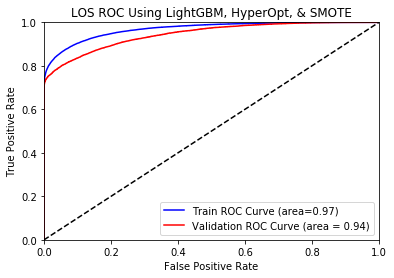

In [108]:
plt.plot(roc_curve(y_train, train_probs_3)[0],roc_curve(y_train, train_probs_3)[1],
         color='blue', label='Train ROC Curve (area=%0.2f)' % roc_auc_score(y_train, train_probs_3))
plt.plot(roc_curve(y_val, val_probs_3)[0],roc_curve(y_val, val_probs_3)[1], 
         color = 'red', label='Validation ROC Curve (area = %0.2f)' % roc_auc_score(y_val, val_probs_3))

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LOS ROC Using LightGBM, HyperOpt, & SMOTE')
plt.legend()
plt.show()

In [111]:
Results['LOS_PRED'] = test_probs_3
Results.to_csv('Results.csv')

In [110]:
np.bincount(Results['LOS_PRED'])

array([11202])

### Train AUC = 0.97, Eval AUC = 0.94! Big improvement!

# Discrimination Threshold Analysis<a name="discrimination"></a>
- - -
 It is common for ML classification algorithms to output probability estimates as a measure of the "certainty" or *confidence* of class predictions. Even though such estimates are predictions of the likelihood or *probability* of class membership, it is sometimes necessary (depending on the purpose/goal of the classification task) to convert them into discrete class labels. For example, let's say that a binary classification model was constructed for the purpose of discriminating between Rock music (Class 0) and RnB music (Class 1). To convert the expected probabilities produced by the model into discrete class predictions, a "decision rule" is established for assigning observations to either Class 0 or Class 1: 
#### If $p_{i} < 0.5$, then $i = C_{0}$ 
#### OR 
#### if $p_{i} > 0.5$, then $i = C_{1}$ were computed. 

Accordingly, if $p_{i} = 0.45$, then $p_{i}$ is converted to Class 0 (i.e. Rock music). This simple decision rule uses the default value (i.e. 0.5) of a parameter known as the "decision threshold" or the "discrimination threshold". However, life (and thus data science) is rarely simple, and there are a number of reasons why one might want/need to consider moving the discrimination threshold from its default value! To name just a couple:

* #### Significant imbalance in class distribution
  * This can lead to high sensitivity in the majority class/classes and low specificity in the minority class/classes, which can be a **very big deal** if there are...

* #### Disproportionate consequence(s) between classes as a result of incorrect predictions
  * For example, it is better for a spam filter to incorrectly allow 10 spam e-mails into a user's inbox than to block a single "good" e-mail. 

Now, given that the target's class distribution is significantly imbalanced, *and* that this model is pertinent to healthcare, it likely goes without saying that the discrimination threshold should be assessed and optimized. To do so, I will first run scikit-learn's implementation of LightGBM as a classifier using the previously obtained hyperparameter values, after which I will use Yellowbrick's Discrimination Threshold visualizer.

In [153]:
lgb_class = LGBMClassifier(
    boosting_type = 'goss',
    objective = 'binary',
    metric = 'auc',
    num_threads  = 4,
    bagging_frequency = 22,
    colsample_bytree = 0.5,
    learning_rate = 0.025,
    max_bin = 90,
    max_depth = 38,
    min_child_weight = 300.0,
    min_data_in_leaf = 5,
    num_leaves = 196,
    reg_alpha = 0.7339122129225384,
    reg_lambda = 81.5894069958651,
    subsample = 1.0)
lgb_class.fit(X_train, y_train)

LGBMClassifier(bagging_frequency=22, boosting_type='goss', class_weight=None,
               colsample_bytree=0.5, importance_type='split',
               learning_rate=0.025, max_bin=90, max_depth=38, metric='auc',
               min_child_samples=20, min_child_weight=300.0, min_data_in_leaf=5,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=196,
               num_threads=4, objective='binary', random_state=None,
               reg_alpha=0.7339122129225384, reg_lambda=81.5894069958651,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [147]:
results_model3 = lgb_baseline.predict(x_pred)
y_train_probs = lgb_baseline.predict(X_train)

fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_probs)
metrics.auc(fpr, tpr)

0.9583465540040976

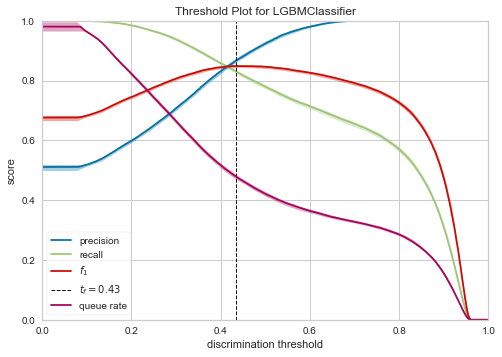

In [157]:
from yellowbrick.classifier import DiscriminationThreshold

visualizer = DiscriminationThreshold(lgb_class)
visualizer.fit(X_train,y_train)
visualizer.show()

### According to the visualization above, the discrimination threshold should be adjusted from the default value ($t_{r} = 0.5$) to $t_{r} = 0.43$. 

Why?

The proposed adjustment is based on the relationship between precision (i.e. $\frac{TP}{TP+FP}$) and recall (i.e. $\frac{TP}{TP+FN}$), as well as the $F_{1}$ score, which is the harmonic mean between precision and recall. By default, Yellowbrick's Discrimination Threshold visualizer optimizes for $F_{1}$ score.

(array([2307., 8895.]), array([0.  , 0.43, 0.99]), <a list of 2 Patch objects>)

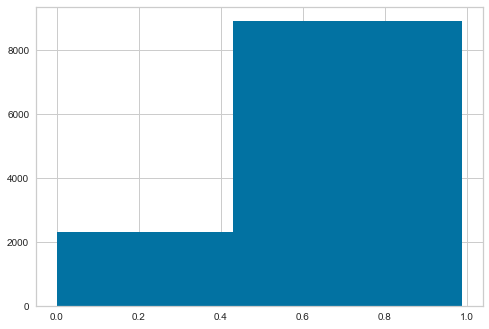

In [161]:
plt.hist(lgb_baseline.predict(x_pred),bins=[0,0.43,0.99])

# Final AUCs: Train = 0.959, Eval = 0.943! 